# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tabulate import tabulate

# Configs

In [2]:
BASE_PATH = "/Users/maedeh/Desktop/data/"

LABELED_PATH = BASE_PATH + "pair_labels_ph2.parquet"
XGB_MODEL_PATH = BASE_PATH + "pairs_xgb_predictions_ph2.parquet"
REGRESSION_MODEL_PATH = BASE_PATH + "pairs_ridge_test_predictions_ph2.parquet"
# RF_MODEL_PATH = BASE_PATH + "RF_predictions_phase1.parquet"

SAVE_PLOT_PATH = BASE_PATH + 'pngs/'

MODEL_LIST = ['BASELINE_LAST_WEEK', 'REGRESSION_MODEL','XGB_MODEL']
CATEGORIES = ['high_demand_pair_locations','mid_demand_pair_locations']
METRICS = ['MAPE', 'MAE', 'RMSE']
BASED_ON = ['PULocation', 'Hour_interval', 'Date', 'Day_of_week']



TEST_START_DATE = '2023-04-01'
LAST_WEEK_TEST_START_DATE = '2023-03-25'

NUM_INTERVAL_PER_DAY = 8

SORT_METHOD = 'mean'

warnings.filterwarnings('ignore')

In [3]:
report_dict = {cat:{met:{model:None for model in MODEL_LIST} for met in METRICS} for cat in CATEGORIES}
predictions_dict = {model:None for model in MODEL_LIST}
sorted_locations_dict={cat:None for cat in CATEGORIES}
predictions_mean_error_dict={model:{based:{cat:None for cat in CATEGORIES} for based in BASED_ON} for model in MODEL_LIST}

# Load Data

## Load labeled data

In [4]:
labeled_df = pd.read_parquet(LABELED_PATH)
print(labeled_df.shape)
labeled_df.head()

(1385280, 5)


,PULocation,Date,DOLocation,Hour_interval,Demand
0,13,2023-01-01,68,0,1.0
1,13,2023-01-01,68,3,1.0
2,13,2023-01-01,68,6,2.0
3,13,2023-01-01,68,9,3.0
4,13,2023-01-01,68,12,8.0


In [5]:
test_df = labeled_df.loc[labeled_df['Date']>=TEST_START_DATE]
test_df = test_df.reset_index(drop = True)
test_df.head()

,PULocation,Date,DOLocation,Hour_interval,Demand
0,13,2023-04-01,68,0,0.0
1,13,2023-04-01,68,3,0.0
2,13,2023-04-01,68,6,1.0
3,13,2023-04-01,68,9,1.0
4,13,2023-04-01,68,12,3.0


## Load Predicted Data

In [6]:
for model in MODEL_LIST:
    if model != 'BASELINE_LAST_WEEK':
        predictions_dict[model] = pd.read_parquet(eval(model + '_PATH'))
        print(f"shape of {model} {predictions_dict[model].shape}")
        display(predictions_dict[model].head())

shape of REGRESSION_MODEL (346320, 5)


,PULocation,Date,DOLocation,Hour_interval,Predicted_demand
0,13,2023-04-01,68,0,-0.266097
1,13,2023-04-01,68,3,0.630272
2,13,2023-04-01,68,6,1.466151
3,13,2023-04-01,68,9,3.924143
4,13,2023-04-01,68,12,4.410310


shape of XGB_MODEL (346320, 5)


,PULocation,Date,DOLocation,Hour_interval,Predicted_demand
0,13,2023-04-01,68,0,0.038683
1,13,2023-04-01,68,3,0.725528
2,13,2023-04-01,68,6,1.809926
3,13,2023-04-01,68,9,3.839591
4,13,2023-04-01,68,12,4.301649


### BaseLine Models

In [7]:
def baseline_predict(dataset, shift_val):
    baseline_test_df = dataset.loc[dataset['Date']>=LAST_WEEK_TEST_START_DATE]
    baseline_test_df = baseline_test_df.reset_index(drop = True)
    predicted_demand = baseline_test_df.groupby(['PULocation', 'DOLocation'])['Demand'].shift(shift_val)
    predicted_data = pd.DataFrame(baseline_test_df[['PULocation', 'Date', 'DOLocation','Hour_interval']])
    predicted_data['Predicted_demand'] = predicted_demand
    predicted_data = predicted_data.dropna()
    return predicted_data

In [8]:
predictions_dict['BASELINE_LAST_WEEK'] = baseline_predict(labeled_df, 7*NUM_INTERVAL_PER_DAY)
print(predictions_dict['BASELINE_LAST_WEEK'].shape)
predictions_dict['BASELINE_LAST_WEEK'].head()

(346320, 5)


,PULocation,Date,DOLocation,Hour_interval,Predicted_demand
56,13,2023-04-01,68,0,0.0
57,13,2023-04-01,68,3,1.0
58,13,2023-04-01,68,6,0.0
59,13,2023-04-01,68,9,4.0
60,13,2023-04-01,68,12,3.0


### Join Predictions and Actual

In [9]:
def join_actual_predict(actual_df, predicted_df):
    for label,predictions_df in predicted_df.items():
        if (predictions_df is not None):
            actual_predicted_df = actual_df.merge(predictions_df, how='left', on=['PULocation', 'Date', 'DOLocation', 'Hour_interval'])
            actual_predicted_df['Date'] = pd.to_datetime(actual_predicted_df['Date'])
            actual_predicted_df['Day_of_week'] = actual_predicted_df['Date'].dt.dayofweek
            predictions_dict[label] = actual_predicted_df

In [10]:
join_actual_predict(test_df,predictions_dict)
for model in MODEL_LIST:
    print(f"shape of predictions_dict[{model}]: {predictions_dict[model].shape}")
    display(predictions_dict[model].head())

shape of predictions_dict[BASELINE_LAST_WEEK]: (346320, 7)


,PULocation,Date,DOLocation,Hour_interval,Demand,Predicted_demand,Day_of_week
0,13,2023-04-01,68,0,0.0,0.0,5
1,13,2023-04-01,68,3,0.0,1.0,5
2,13,2023-04-01,68,6,1.0,0.0,5
3,13,2023-04-01,68,9,1.0,4.0,5
4,13,2023-04-01,68,12,3.0,3.0,5


shape of predictions_dict[REGRESSION_MODEL]: (346320, 7)


,PULocation,Date,DOLocation,Hour_interval,Demand,Predicted_demand,Day_of_week
0,13,2023-04-01,68,0,0.0,-0.266097,5
1,13,2023-04-01,68,3,0.0,0.630272,5
2,13,2023-04-01,68,6,1.0,1.466151,5
3,13,2023-04-01,68,9,1.0,3.924143,5
4,13,2023-04-01,68,12,3.0,4.410310,5


shape of predictions_dict[XGB_MODEL]: (346320, 7)


,PULocation,Date,DOLocation,Hour_interval,Demand,Predicted_demand,Day_of_week
0,13,2023-04-01,68,0,0.0,0.038683,5
1,13,2023-04-01,68,3,0.0,0.725528,5
2,13,2023-04-01,68,6,1.0,1.809926,5
3,13,2023-04-01,68,9,1.0,3.839591,5
4,13,2023-04-01,68,12,3.0,4.301649,5


### Sort Locations by Demand

In [11]:
def sort_locations_on_demand(predictions_dict,sorted_locations_dict):
    predictions_df = predictions_dict['BASELINE_LAST_WEEK']
    if (predictions_df is not None):
        pair_df = predictions_df.groupby(['PULocation','DOLocation'])['Demand'].aggregate([SORT_METHOD]).sort_values(SORT_METHOD, ascending=False)
        pair_df = pair_df.reset_index()
        pair_df = predictions_df.merge(pair_df, how='right', on=['PULocation','DOLocation'])
        pair_df = pair_df[['PULocation','DOLocation','Hour_interval',SORT_METHOD]].drop_duplicates()
        pair_min_df = predictions_df.groupby(['PULocation', 'DOLocation','Hour_interval'])['Demand'].aggregate(['min']).sort_values('min',ascending=False)
        pair_min_df = pair_min_df.reset_index()
        high_index = pair_min_df[~pair_min_df['min'].isin([0])]
        mid_index = pair_min_df[pair_min_df['min'].isin([0])]
        
        sorted_locations_dict[CATEGORIES[0]] = pair_df.merge(high_index[['PULocation','DOLocation','Hour_interval']], on=['PULocation','DOLocation','Hour_interval'])
        sorted_locations_dict[CATEGORIES[1]] = pair_df.merge(mid_index[['PULocation','DOLocation','Hour_interval']], on=['PULocation','DOLocation','Hour_interval'])
    

In [12]:
sort_locations_on_demand(predictions_dict, sorted_locations_dict)
for cat in CATEGORIES:
    print(f"shape of sorted_locations_dict[{cat}]: {sorted_locations_dict[cat].shape}")
    display(sorted_locations_dict[cat].head())

shape of sorted_locations_dict[high_demand_pair_locations]: (5570, 4)


,PULocation,DOLocation,Hour_interval,mean
0,264,264,0,131.279167
1,264,264,3,131.279167
2,264,264,6,131.279167
3,264,264,9,131.279167
4,264,264,12,131.279167


shape of sorted_locations_dict[mid_demand_pair_locations]: (5974, 4)


,PULocation,DOLocation,Hour_interval,mean
0,237,236,3,94.612500
1,236,237,0,79.520833
2,236,237,3,79.520833
3,237,237,0,62.541667
4,237,237,3,62.541667


# Mean error Calculation

### Error Columns

In [13]:
def calculate_error(actual_predicted_dict: dict):
    for label,actual_predicted_df in actual_predicted_dict.items():
        if (actual_predicted_df is not None):
            
            actual_predicted_df['error'] = np.abs(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            
            actual_predicted_df['squared_error'] = np.square(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            
            actual_Demand_df = np.where(actual_predicted_df['Demand']==0, 1, actual_predicted_df['Demand'])
            actual_predicted_df['percentage_error'] = (
                actual_predicted_df['error']/actual_Demand_df
                )*100
            

In [14]:
calculate_error(predictions_dict)
for model in MODEL_LIST:
    print(f"shape of predictions_dict[{model}]: {predictions_dict[model].shape}")
    display(predictions_dict[model].head())

shape of predictions_dict[BASELINE_LAST_WEEK]: (346320, 10)


,PULocation,Date,DOLocation,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,13,2023-04-01,68,0,0.0,0.0,5,0.0,0.0,0.0
1,13,2023-04-01,68,3,0.0,1.0,5,1.0,1.0,100.0
2,13,2023-04-01,68,6,1.0,0.0,5,1.0,1.0,100.0
3,13,2023-04-01,68,9,1.0,4.0,5,3.0,9.0,300.0
4,13,2023-04-01,68,12,3.0,3.0,5,0.0,0.0,0.0


shape of predictions_dict[REGRESSION_MODEL]: (346320, 10)


,PULocation,Date,DOLocation,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,13,2023-04-01,68,0,0.0,-0.266097,5,0.266097,0.070808,26.609722
1,13,2023-04-01,68,3,0.0,0.630272,5,0.630272,0.397242,63.027176
2,13,2023-04-01,68,6,1.0,1.466151,5,0.466151,0.217297,46.615100
3,13,2023-04-01,68,9,1.0,3.924143,5,2.924143,8.550613,292.414305
4,13,2023-04-01,68,12,3.0,4.410310,5,1.410310,1.988974,47.010325


shape of predictions_dict[XGB_MODEL]: (346320, 10)


,PULocation,Date,DOLocation,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,13,2023-04-01,68,0,0.0,0.038683,5,0.038683,0.001496,3.868270
1,13,2023-04-01,68,3,0.0,0.725528,5,0.725528,0.526391,72.552818
2,13,2023-04-01,68,6,1.0,1.809926,5,0.809926,0.655980,80.992603
3,13,2023-04-01,68,9,1.0,3.839591,5,2.839591,8.063274,283.959055
4,13,2023-04-01,68,12,3.0,4.301649,5,1.301649,1.694289,43.388287


### Aggregate Error Columns

In [15]:
def calculate_mean_error(actual_predicted_dict: dict, predictions_mean_dict: dict):
    for model,actual_predicted_df in actual_predicted_dict.items():
        
        if (actual_predicted_df is not None):
            for cat in CATEGORIES:
                
                sorted_locations = sorted_locations_dict[cat]
                categorized_df = actual_predicted_df.merge(sorted_locations[['PULocation','DOLocation','Hour_interval']], on=['PULocation','DOLocation','Hour_interval'])
                
                for per in BASED_ON:
                    
                    if per!='PULocation':
                        categorized_error_df = categorized_df[[per,'Demand','error','squared_error', 'percentage_error']]
                        categorized_mean_df = (
                            categorized_error_df.groupby(per).agg(mape=('percentage_error','mean'),
                                                                  mae=('error','mean'),
                                                                  mse=('squared_error','mean'),
                                                                  demand_mean=('Demand','mean'))
                                                                  ) 
                        categorized_mean_df['rmse'] = np.sqrt(categorized_mean_df['mse'])
                        categorized_mean_df.drop(columns='mse', inplace=True)
                        categorized_mean_df['mape'] = np.where(categorized_mean_df['mape']>100, 100, categorized_mean_df['mape'])
                        
                        if per=='Hour_interval':
                            hour_demand_index = sorted_locations.groupby(['Hour_interval'])[SORT_METHOD].sum().sort_values(ascending=False).index
                            categorized_mean_df = categorized_mean_df.reindex(hour_demand_index)
                            
                    else:
                        categorized_error_df = categorized_df[['PULocation','DOLocation','Demand','error','squared_error', 'percentage_error']]
                        categorized_mean_df = (
                            categorized_error_df.groupby(['PULocation','DOLocation']).agg(mape=('percentage_error','mean'),
                                                                  mae=('error','mean'),
                                                                  mse=('squared_error','mean'),
                                                                  demand_mean=('Demand','mean'))
                                                                  ) 
                        categorized_mean_df['rmse'] = np.sqrt(categorized_mean_df['mse'])
                        categorized_mean_df.drop(columns=['mse'], inplace=True)
                        categorized_mean_df['mape'] = np.where(categorized_mean_df['mape']>100, 100, categorized_mean_df['mape'])
                        loc_demand_index = sorted_locations.groupby(['PULocation','DOLocation'])[SORT_METHOD].sum().sort_values(ascending=False).index
                        categorized_mean_df = categorized_mean_df.reindex(loc_demand_index)
    
                    
                    predictions_mean_dict[model][per][cat] = categorized_mean_df.reset_index()


In [16]:
calculate_mean_error(predictions_dict, predictions_mean_error_dict)
for model in MODEL_LIST:
    for per in BASED_ON:
        for cat in CATEGORIES:
            print(f"shape of predictions_mean_error_dict[{model}][{per}][{cat}]: {predictions_mean_error_dict[model][per][cat].shape}")
            display(predictions_mean_error_dict[model][per][cat].head())

shape of predictions_mean_error_dict[BASELINE_LAST_WEEK][PULocation][high_demand_pair_locations]: (1395, 6)


,PULocation,DOLocation,mape,mae,demand_mean,rmse
0,264,264,28.250137,27.787500,131.279167,37.448687
1,237,236,25.779861,18.866667,108.019048,25.149837
2,236,237,20.963900,18.444444,105.483333,24.637821
3,237,237,21.246079,15.233333,82.250000,20.662096
4,236,236,23.263051,16.955556,81.633333,21.942096


shape of predictions_mean_error_dict[BASELINE_LAST_WEEK][PULocation][mid_demand_pair_locations]: (1440, 6)


,PULocation,DOLocation,mape,mae,demand_mean,rmse
0,236,237,84.841270,1.300000,1.633333,1.807392
1,237,237,56.355570,1.800000,3.416667,2.863564
2,236,236,80.216117,1.983333,3.116667,2.655184
3,237,236,49.444444,0.566667,0.766667,0.836660
4,236,161,47.883338,4.644444,20.255556,10.594548


shape of predictions_mean_error_dict[BASELINE_LAST_WEEK][Hour_interval][high_demand_pair_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,15,48.852843,4.492496,14.080628,6.508347
1,18,50.271242,4.640379,13.811042,6.769647
2,12,49.810748,4.285220,13.421734,6.186210
3,9,51.506768,4.064283,12.107692,5.922559
4,21,54.582492,4.285189,11.580530,6.153790


shape of predictions_mean_error_dict[BASELINE_LAST_WEEK][Hour_interval][mid_demand_pair_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,3,51.450468,0.763628,0.860098,1.407387
1,0,74.588503,1.702674,2.737135,2.896125
2,6,75.184675,1.651550,2.875969,2.485204
3,21,81.515954,2.248845,3.877146,3.161220
4,9,87.513099,1.895256,2.957692,2.562251


shape of predictions_mean_error_dict[BASELINE_LAST_WEEK][Date][high_demand_pair_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,49.589708,4.443447,12.946858,6.338818
1,2023-04-02,52.192274,3.714004,10.571095,5.425933
2,2023-04-03,52.683001,4.246679,11.898384,6.418443
3,2023-04-04,46.384544,4.235907,13.429982,6.287630
4,2023-04-05,47.914609,4.768223,14.393537,7.137267


shape of predictions_mean_error_dict[BASELINE_LAST_WEEK][Date][mid_demand_pair_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,72.135323,1.781051,3.321727,2.672380
1,2023-04-02,74.632065,1.733177,3.088383,2.622429
2,2023-04-03,64.999968,1.313525,2.049883,2.139862
3,2023-04-04,67.832074,1.379143,2.185973,2.209522
4,2023-04-05,66.864446,1.490626,2.435889,2.349202


shape of predictions_mean_error_dict[BASELINE_LAST_WEEK][Day_of_week][high_demand_pair_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,52.459144,3.988600,11.743806,5.847724
1,1,47.002926,4.197352,13.678456,6.037804
2,2,46.877498,4.489048,14.371634,6.608003
3,3,46.542290,4.524731,14.476616,6.550998
4,4,48.077489,4.568088,13.859605,6.589104


shape of predictions_mean_error_dict[BASELINE_LAST_WEEK][Day_of_week][mid_demand_pair_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,68.773681,1.368639,2.046828,2.181398
1,1,67.236739,1.400234,2.269961,2.195691
2,2,68.831379,1.511592,2.482926,2.356183
3,3,71.653436,1.613827,2.651281,2.479325
4,4,73.229424,1.694384,2.766656,2.544507


shape of predictions_mean_error_dict[REGRESSION_MODEL][PULocation][high_demand_pair_locations]: (1395, 6)


,PULocation,DOLocation,mape,mae,demand_mean,rmse
0,264,264,30.771723,23.208566,131.279167,29.737337
1,237,236,32.440950,16.539936,108.019048,21.871008
2,236,237,19.969446,16.548998,105.483333,21.834123
3,237,237,21.279448,12.962532,82.250000,17.131609
4,236,236,20.933084,13.403342,81.633333,17.876541


shape of predictions_mean_error_dict[REGRESSION_MODEL][PULocation][mid_demand_pair_locations]: (1440, 6)


,PULocation,DOLocation,mape,mae,demand_mean,rmse
0,236,237,100.000000,1.591076,1.633333,1.933273
1,237,237,78.778786,1.587484,3.416667,2.100597
2,236,236,77.740162,1.653845,3.116667,2.087249
3,237,236,100.000000,1.345363,0.766667,1.610558
4,236,161,100.000000,6.185652,20.255556,10.275102


shape of predictions_mean_error_dict[REGRESSION_MODEL][Hour_interval][high_demand_pair_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,15,40.639715,3.533716,14.080628,5.121063
1,18,42.550011,3.624971,13.811042,5.156767
2,12,41.698632,3.386111,13.421734,4.884207
3,9,42.724419,3.185047,12.107692,4.607830
4,21,49.223230,3.474788,11.580530,4.912515


shape of predictions_mean_error_dict[REGRESSION_MODEL][Hour_interval][mid_demand_pair_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,3,56.637930,0.757397,0.860098,1.148582
1,0,83.572833,1.561668,2.737135,2.387339
2,6,66.963467,1.382484,2.875969,2.002248
3,21,72.981977,1.804070,3.877146,2.443109
4,9,71.566702,1.509433,2.957692,1.980988


shape of predictions_mean_error_dict[REGRESSION_MODEL][Date][high_demand_pair_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,41.876215,3.419409,12.946858,4.807413
1,2023-04-02,53.913077,3.273512,10.571095,4.633725
2,2023-04-03,46.808905,3.368718,11.898384,5.148171
3,2023-04-04,38.148406,3.330816,13.429982,4.957012
4,2023-04-05,41.449881,3.951044,14.393537,5.976516


shape of predictions_mean_error_dict[REGRESSION_MODEL][Date][mid_demand_pair_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,67.612450,1.458981,3.321727,2.117183
1,2023-04-02,72.046288,1.476431,3.088383,2.100743
2,2023-04-03,94.544887,1.485364,2.049883,2.268562
3,2023-04-04,67.133674,1.202208,2.185973,1.758481
4,2023-04-05,69.259256,1.341637,2.435889,1.971791


shape of predictions_mean_error_dict[REGRESSION_MODEL][Day_of_week][high_demand_pair_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,48.116357,3.261366,11.743806,4.794964
1,1,38.457723,3.272305,13.678456,4.677743
2,2,38.463844,3.456775,14.371634,5.028385
3,3,38.000498,3.539580,14.476616,5.114610
4,4,39.188643,3.565314,13.859605,5.092309


shape of predictions_mean_error_dict[REGRESSION_MODEL][Day_of_week][mid_demand_pair_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,87.634021,1.415048,2.046828,2.113691
1,1,64.569407,1.205182,2.269961,1.738952
2,2,66.547427,1.298285,2.482926,1.890476
3,3,66.899504,1.368351,2.651281,1.982432
4,4,67.397764,1.450769,2.766656,2.111605


shape of predictions_mean_error_dict[XGB_MODEL][PULocation][high_demand_pair_locations]: (1395, 6)


,PULocation,DOLocation,mape,mae,demand_mean,rmse
0,264,264,28.127361,21.301238,131.279167,28.033586
1,237,236,23.160739,13.608902,108.019048,17.416126
2,236,237,16.948614,14.797080,105.483333,19.698178
3,237,237,17.055884,11.454651,82.250000,15.320562
4,236,236,17.123532,12.263151,81.633333,16.433194


shape of predictions_mean_error_dict[XGB_MODEL][PULocation][mid_demand_pair_locations]: (1440, 6)


,PULocation,DOLocation,mape,mae,demand_mean,rmse
0,236,237,74.154814,1.140144,1.633333,1.310474
1,237,237,57.687288,1.220982,3.416667,1.566902
2,236,236,47.461403,1.123046,3.116667,1.393048
3,237,236,61.699847,0.669216,0.766667,0.775628
4,236,161,50.617992,4.244816,20.255556,9.032757


shape of predictions_mean_error_dict[XGB_MODEL][Hour_interval][high_demand_pair_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,15,36.659975,3.104538,14.080628,4.492046
1,18,38.451327,3.159939,13.811042,4.508718
2,12,37.644284,2.964352,13.421734,4.310897
3,9,38.792387,2.787453,12.107692,4.067667
4,21,43.583316,2.932369,11.580530,4.198861


shape of predictions_mean_error_dict[XGB_MODEL][Hour_interval][mid_demand_pair_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,3,43.803087,0.576538,0.860098,0.825906
1,0,58.633550,1.072804,2.737135,1.554284
2,6,61.287751,1.202842,2.875969,1.680850
3,21,67.967756,1.559337,3.877146,2.067199
4,9,67.783111,1.317995,2.957692,1.672811


shape of predictions_mean_error_dict[XGB_MODEL][Date][high_demand_pair_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,36.539556,2.808125,12.946858,4.010834
1,2023-04-02,45.867498,2.781405,10.571095,4.005057
2,2023-04-03,40.392233,2.988916,11.898384,4.376099
3,2023-04-04,34.322221,2.850439,13.429982,3.986887
4,2023-04-05,36.418027,3.252874,14.393537,4.859897


shape of predictions_mean_error_dict[XGB_MODEL][Date][mid_demand_pair_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,56.518859,1.120654,3.321727,1.571845
1,2023-04-02,61.340087,1.147504,3.088383,1.614374
2,2023-04-03,60.413915,1.066498,2.049883,1.540336
3,2023-04-04,57.696390,1.036887,2.185973,1.477179
4,2023-04-05,57.453947,1.099698,2.435889,1.567844


shape of predictions_mean_error_dict[XGB_MODEL][Day_of_week][high_demand_pair_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,42.877132,2.984348,11.743806,4.352725
1,1,34.750086,2.837856,13.678456,3.980509
2,2,33.687072,2.887169,14.371634,4.157664
3,3,33.026639,2.994302,14.476616,4.340758
4,4,34.754190,3.086231,13.859605,4.504922


shape of predictions_mean_error_dict[XGB_MODEL][Day_of_week][mid_demand_pair_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,61.802553,1.085741,2.046828,1.568352
1,1,56.059492,1.035214,2.269961,1.453634
2,2,56.691663,1.085241,2.482926,1.524242
3,3,56.817744,1.137721,2.651281,1.603733
4,4,58.492869,1.212903,2.766656,1.726361


### Plot Mape for Models Predicted Demands

In [17]:
def plot(predictions_mean_dict, per):
        fig, axes = plt.subplots(nrows=len(CATEGORIES)*len(METRICS), ncols=1, figsize=(15,20))
        for i, met in enumerate(METRICS):
            for j, cat in enumerate(CATEGORIES):
                for model,mean_df in predictions_mean_dict.items():
                    categorized_demand_df = mean_df[per][cat]
                    if (categorized_demand_df is not None):
                        if per!='PULocation':
                            categorized_demand_df[per] = categorized_demand_df[per].astype(str)
                            categorized_demand_df.plot(x=per,y=met.lower(),kind='line',marker='.',ax = axes[len(CATEGORIES)*i+j],label=model)            
                        else:
                            categorized_demand_df['pair_locations'] = [(a,b) for a,b in zip(categorized_demand_df['PULocation'],categorized_demand_df['DOLocation'])]
                            categorized_demand_df['pair_locations'] = categorized_demand_df['pair_locations'].astype(str)
                            categorized_demand_df.plot(x='pair_locations',y=met.lower(),kind='line',marker='.',ax = axes[len(CATEGORIES)*i+j],label=model)            
        
                axes[len(CATEGORIES)*i+j].set_title('Models '+met+' for '+cat, bbox=dict( alpha=0.5)) 
                axes[len(CATEGORIES)*i+j].legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.tight_layout()
        plt.show()
    # plot_name = SAVE_PLOT_PATH + 'MAPE_plot per '+per+'.svg'
    # plt.savefig(plot_name, format='svg', dpi=1200)  


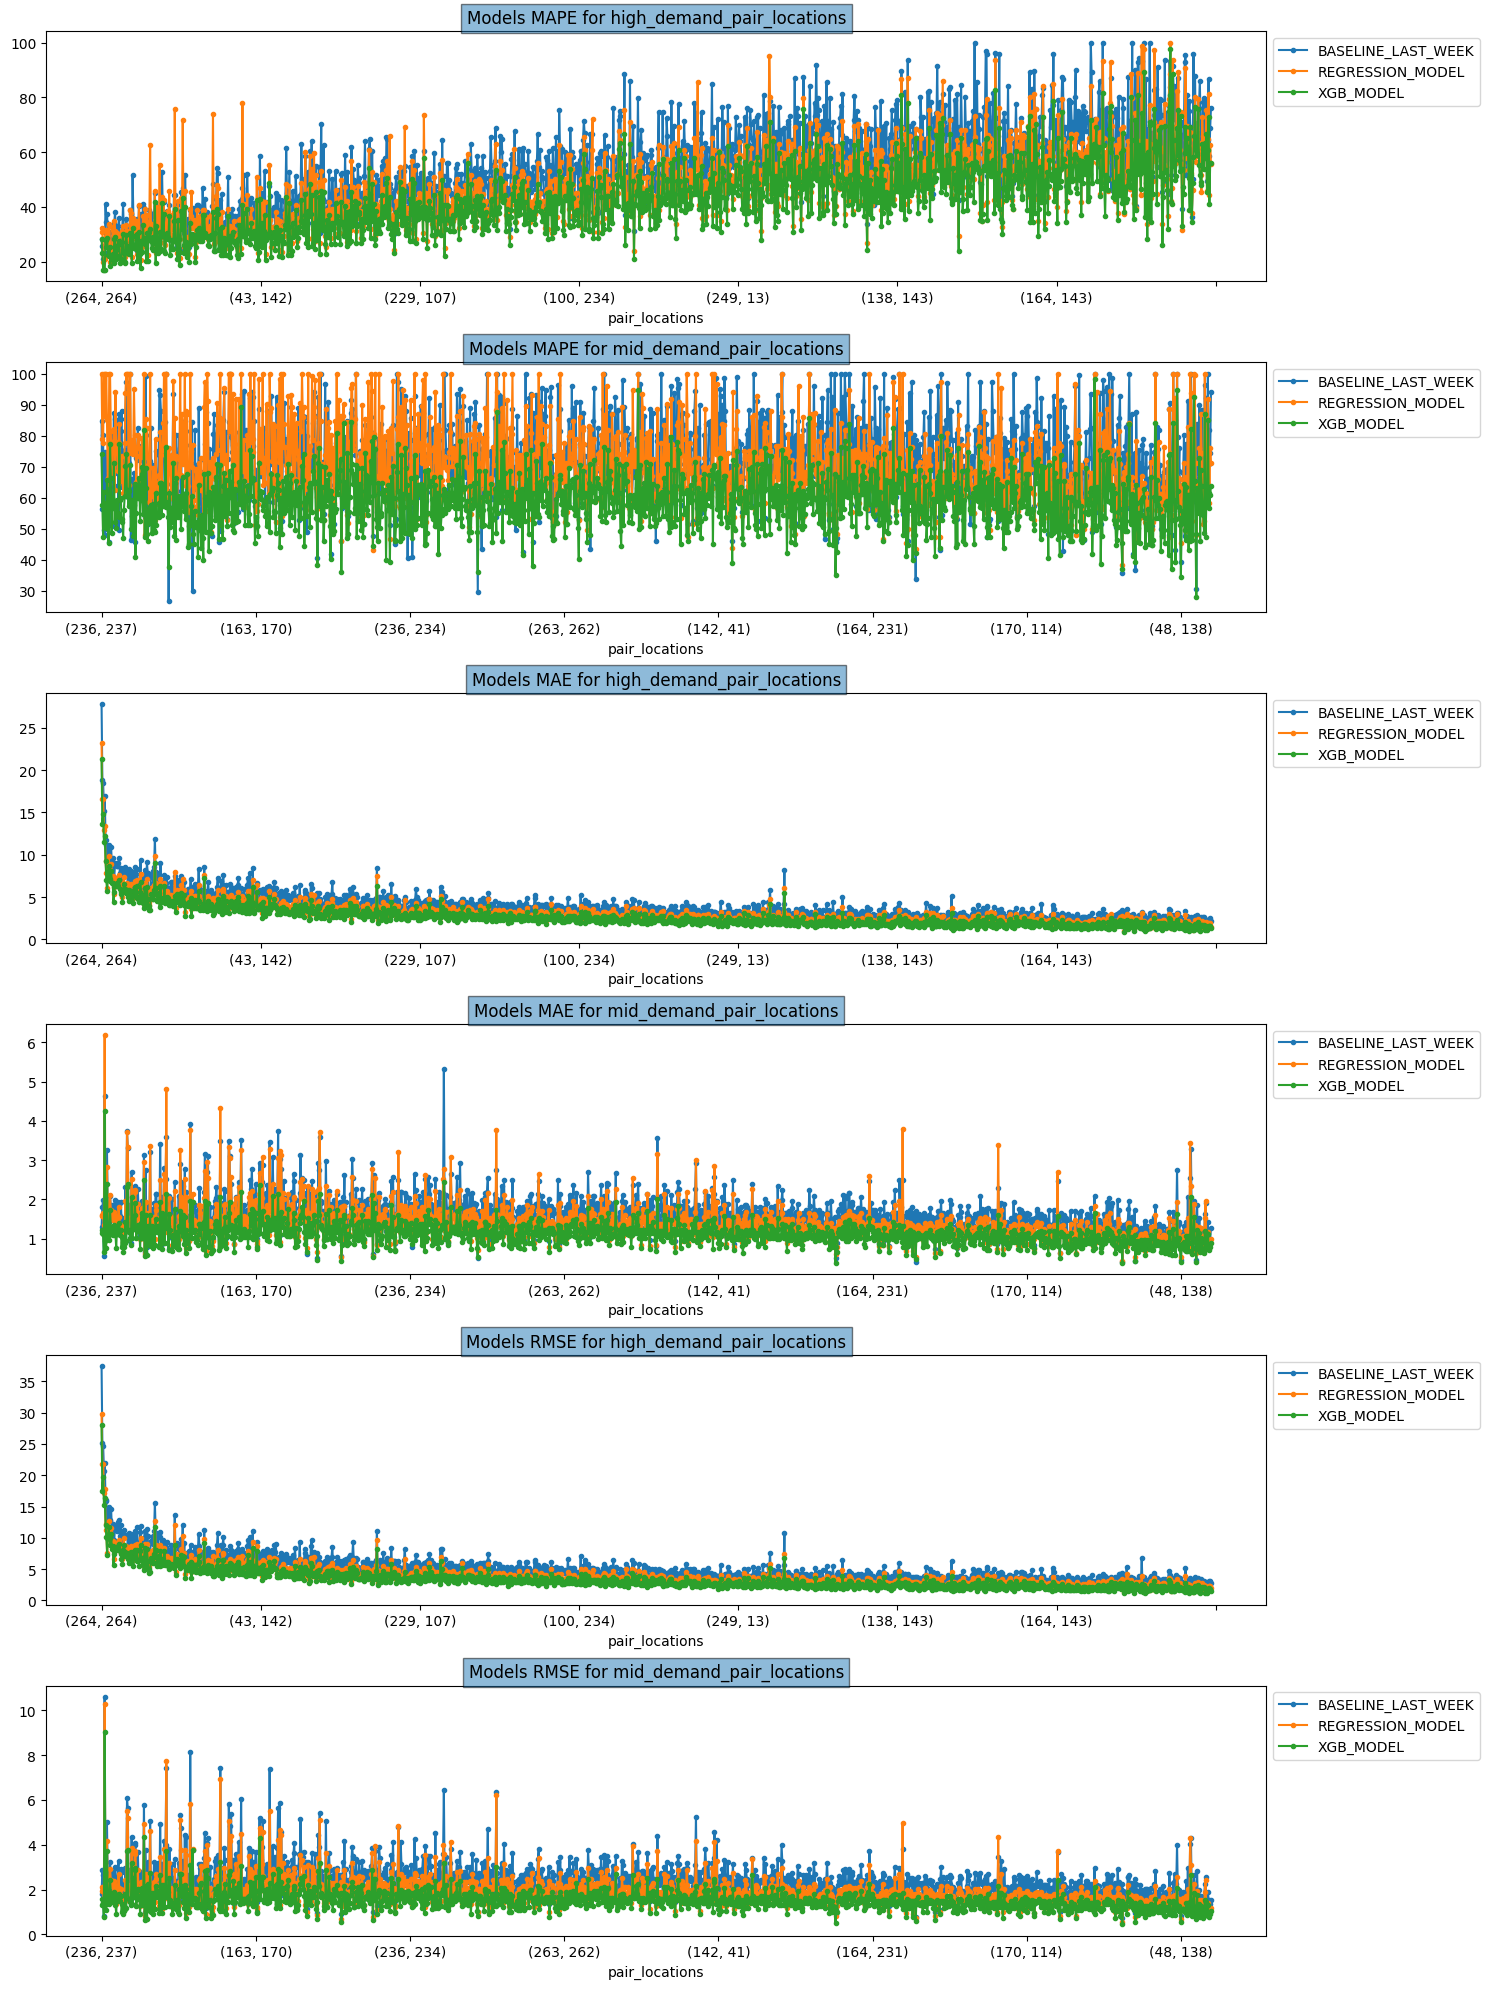

In [18]:
plot(predictions_mean_error_dict, 'PULocation')

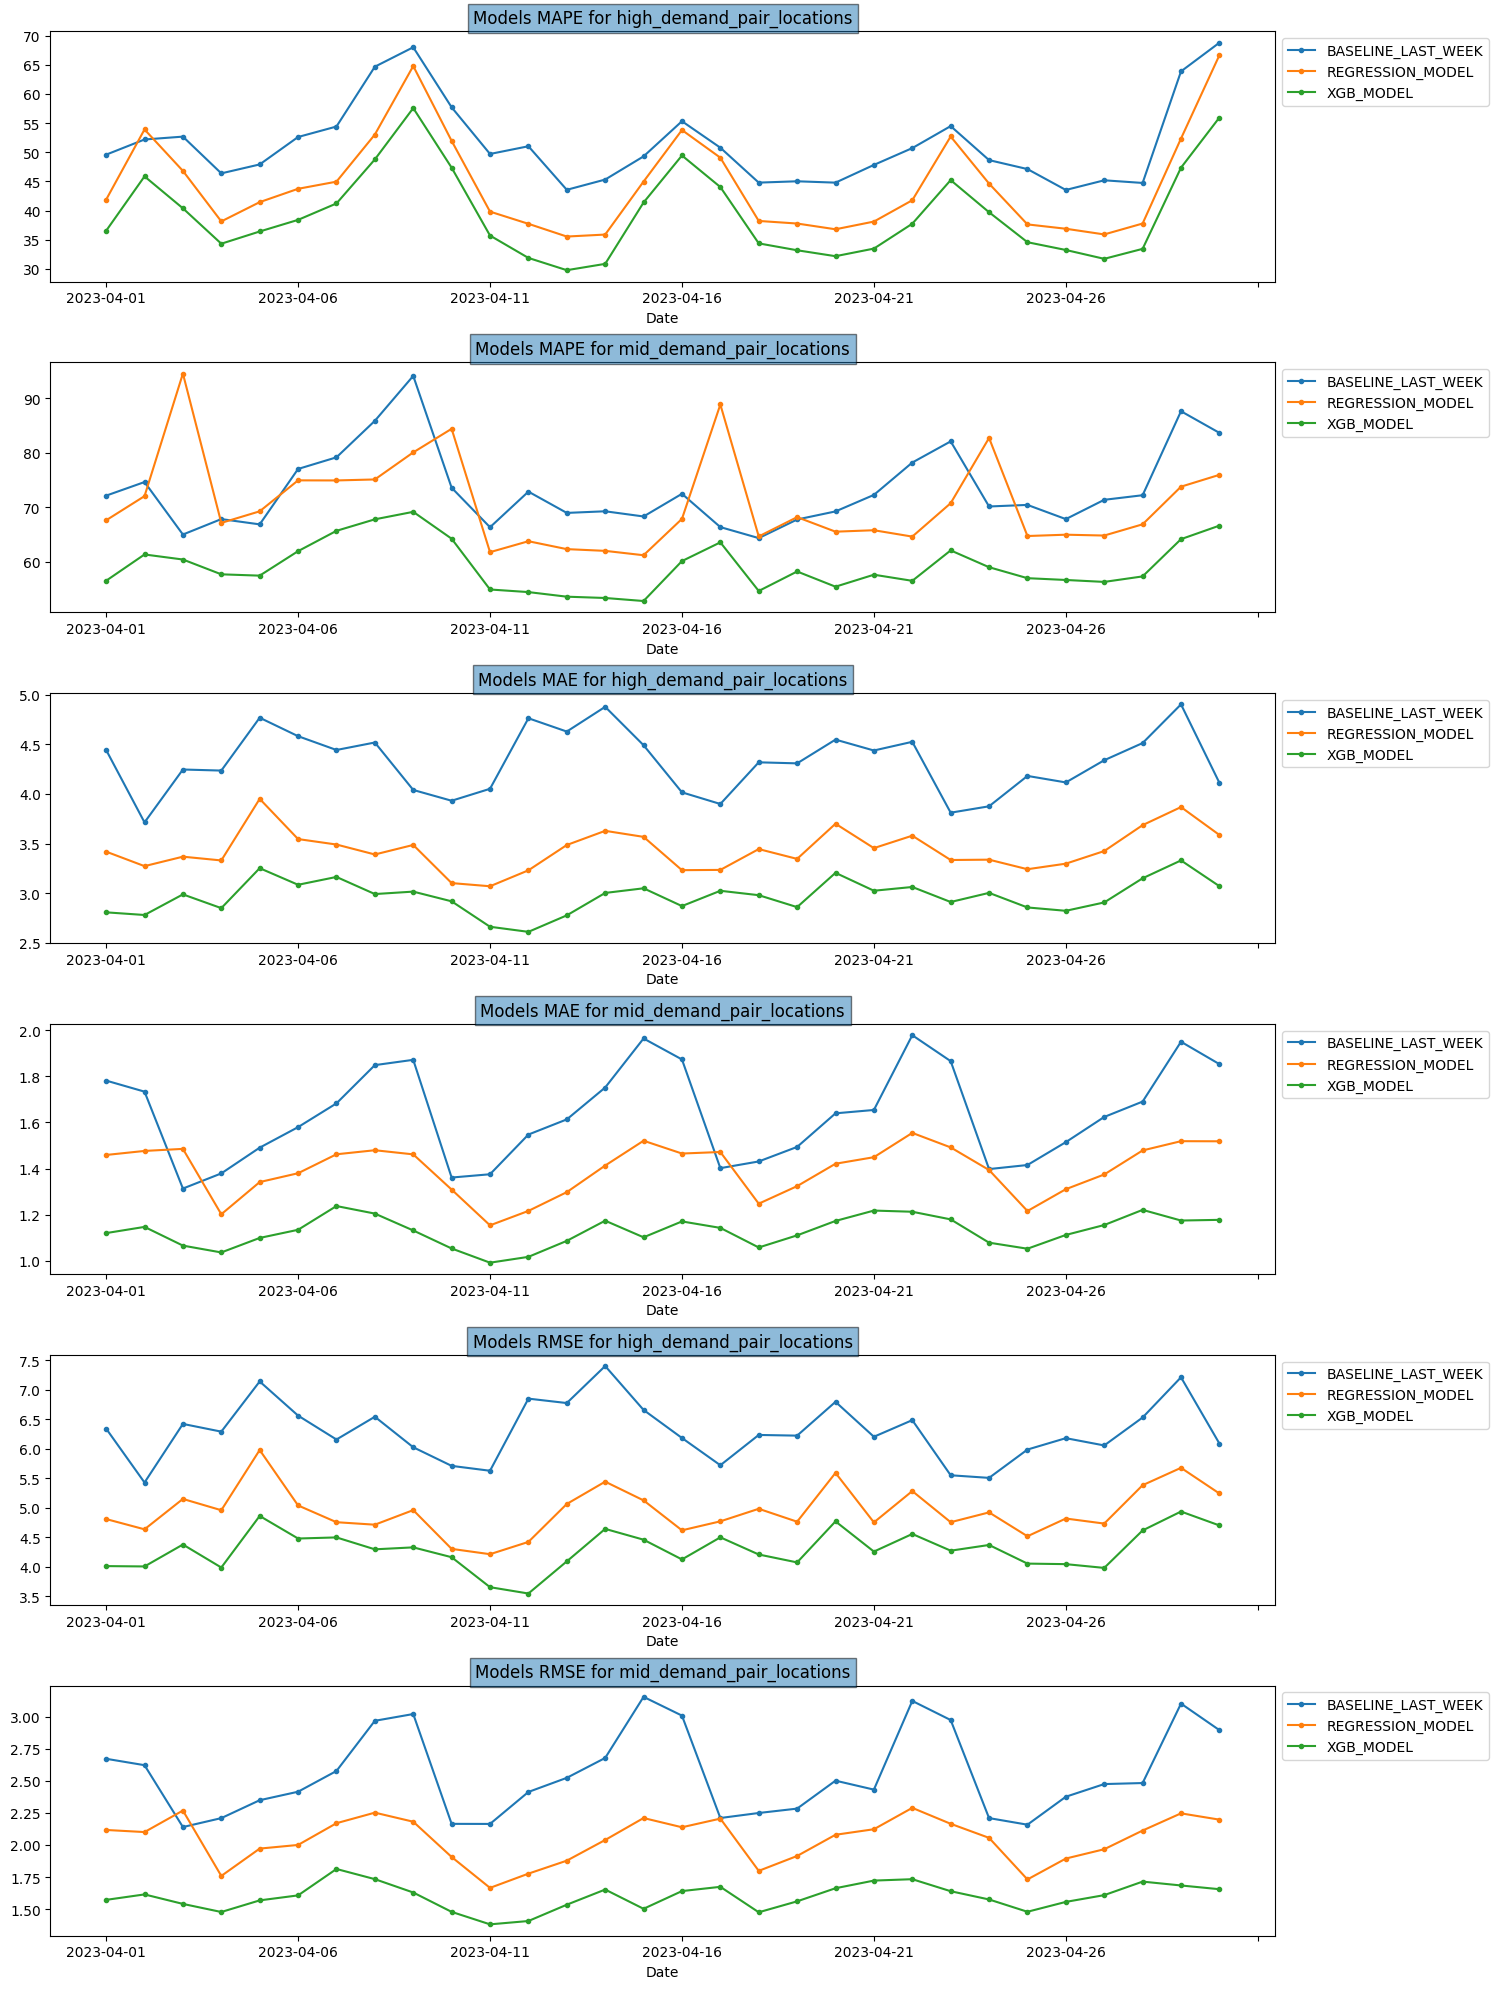

In [19]:
plot(predictions_mean_error_dict, 'Date')

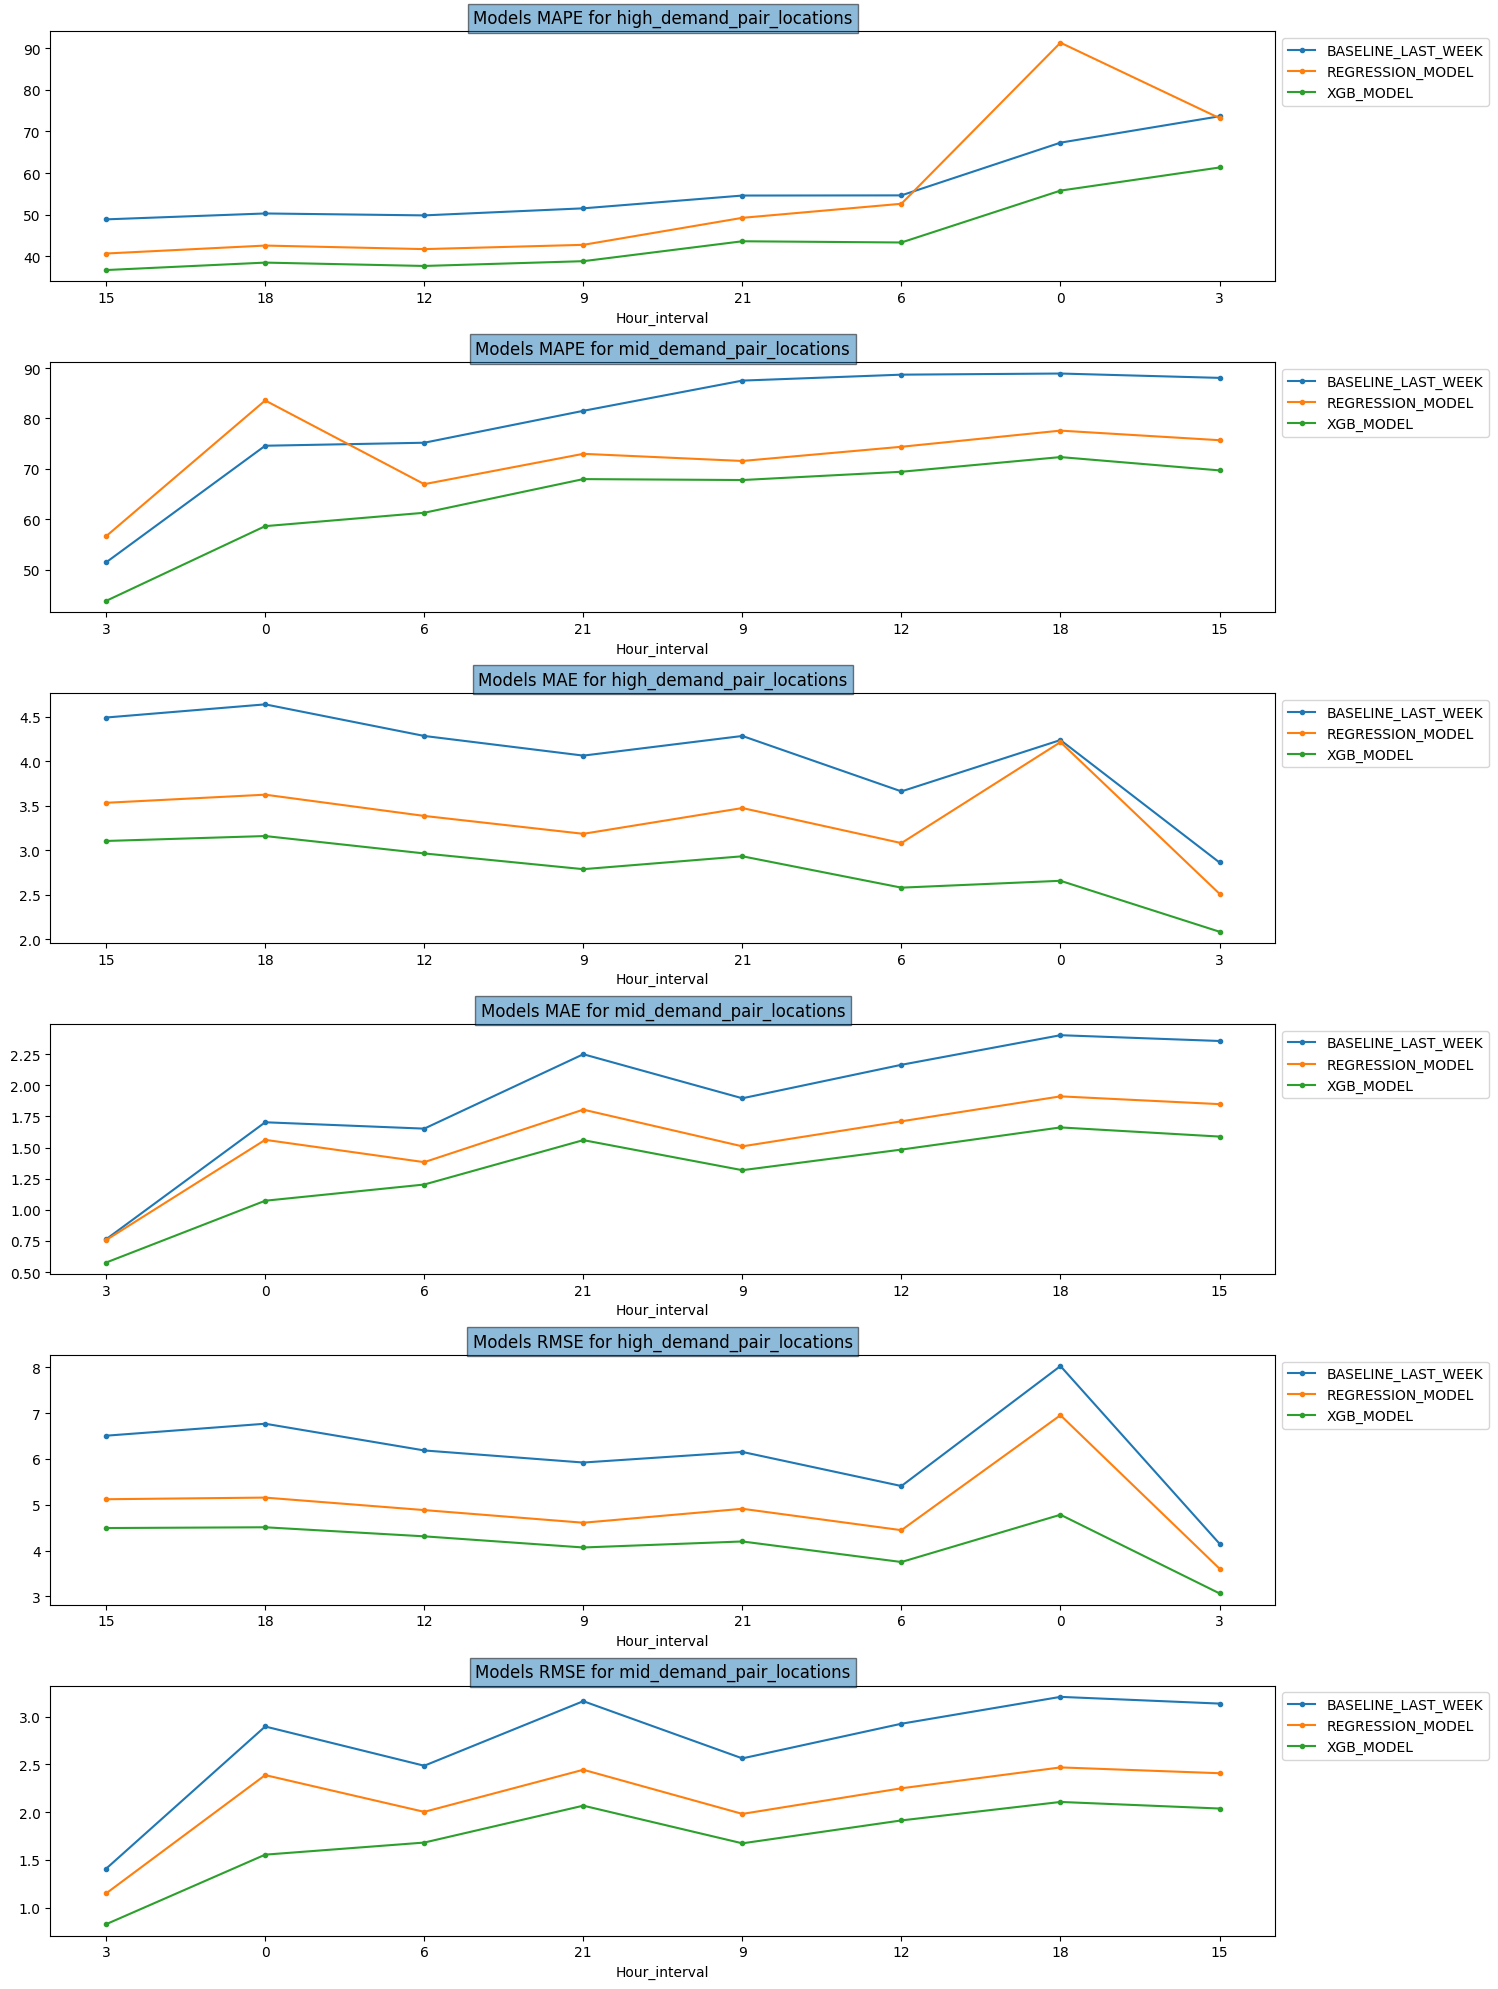

In [20]:
plot(predictions_mean_error_dict, 'Hour_interval')

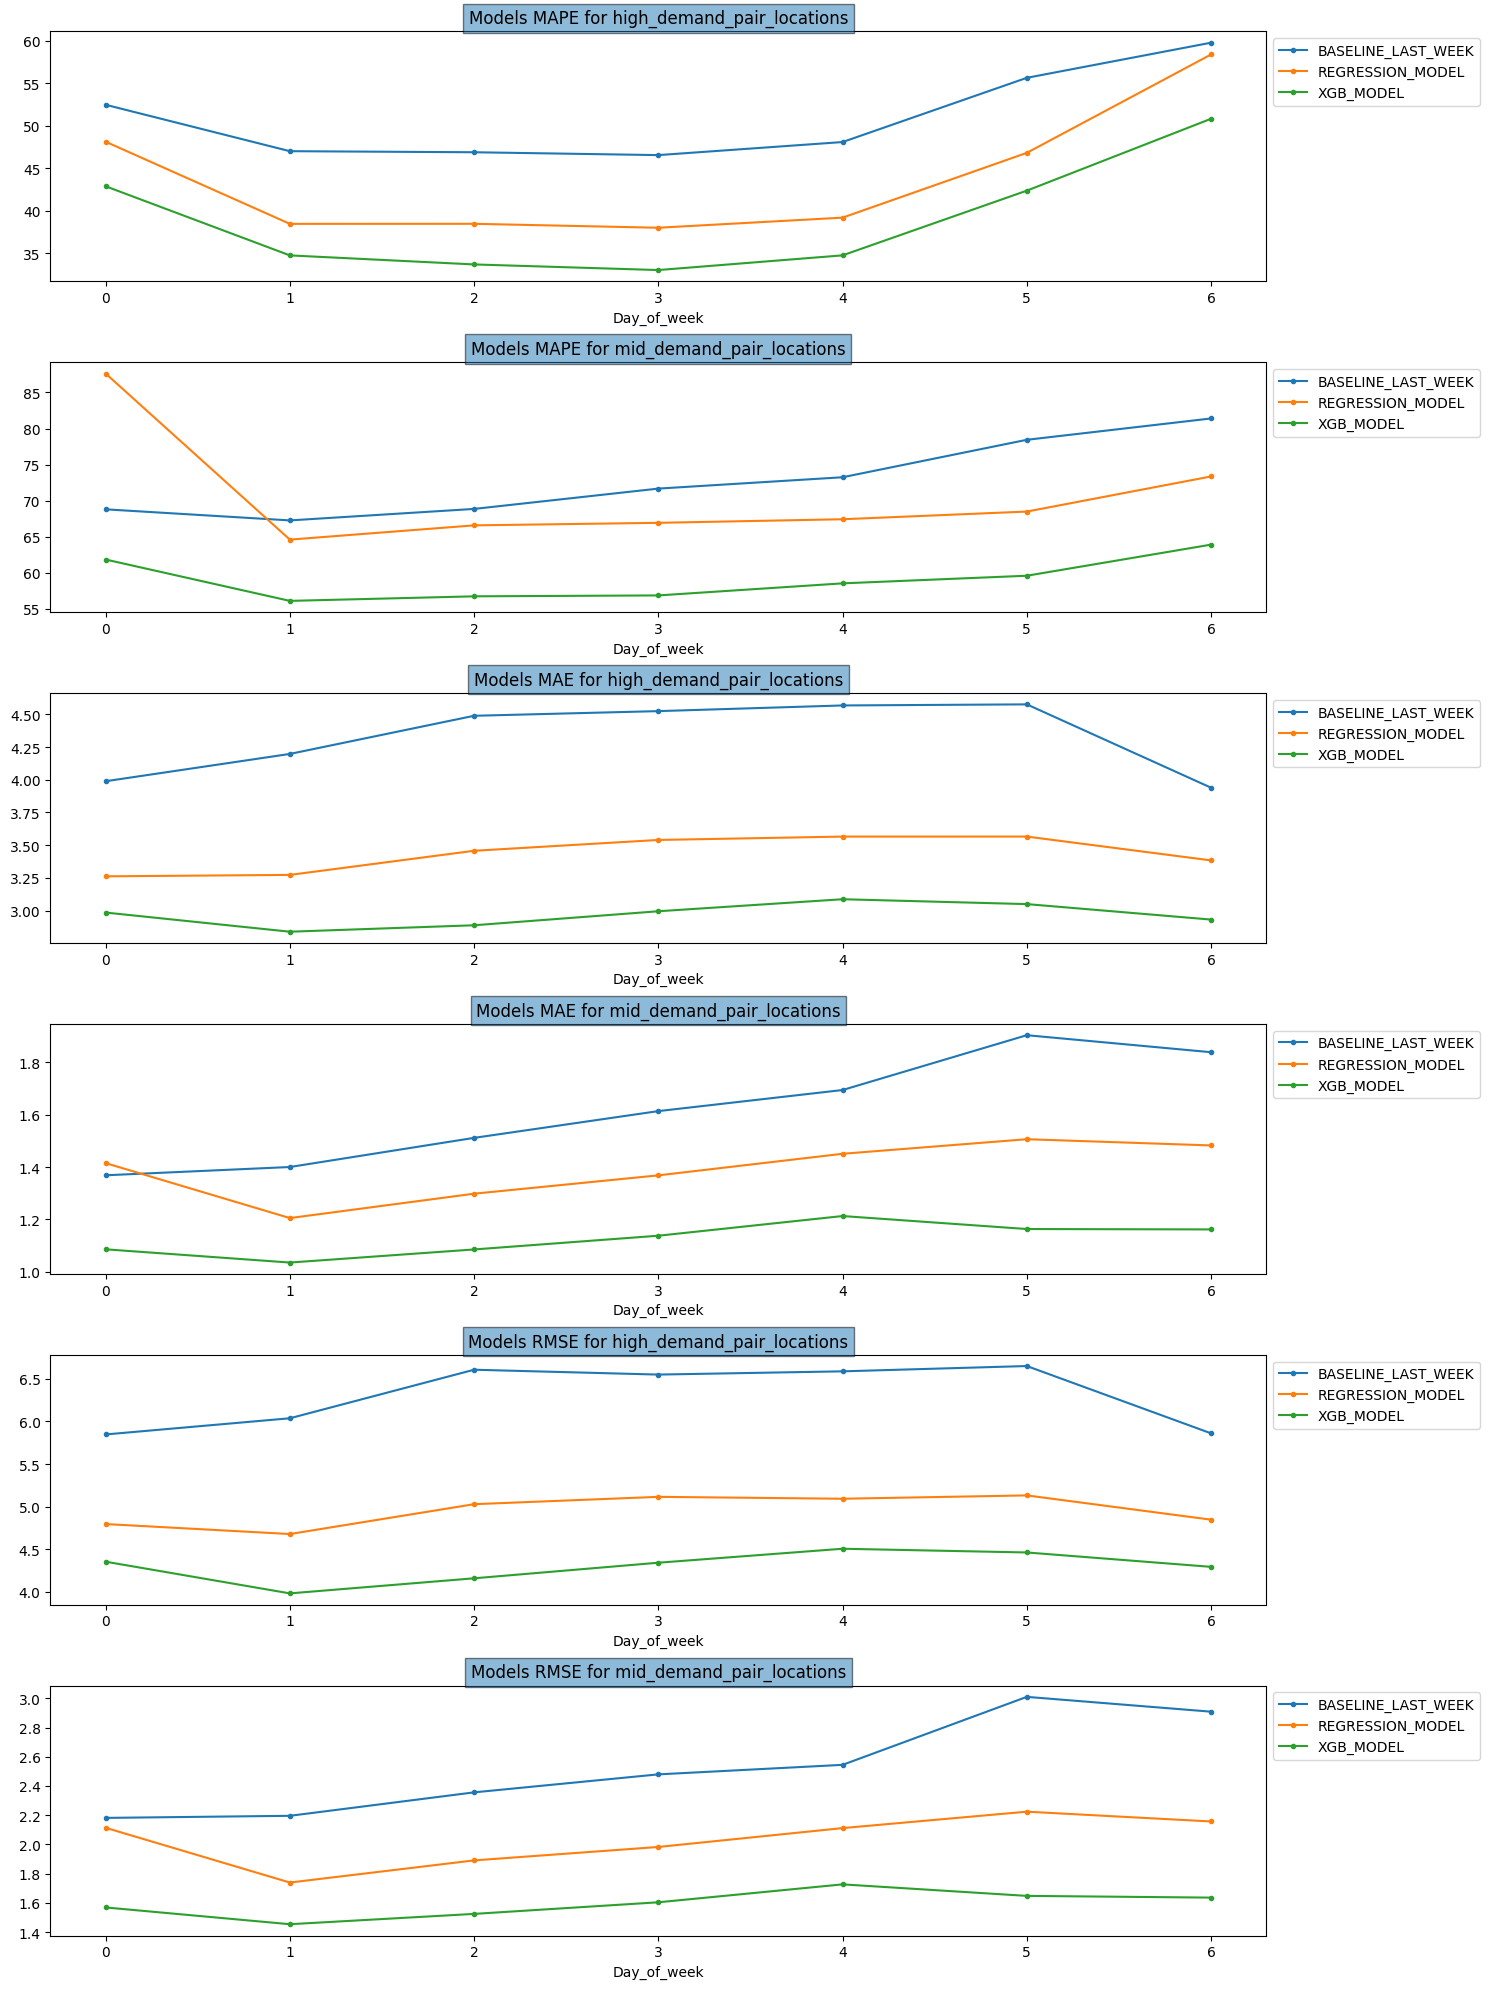

In [21]:
plot(predictions_mean_error_dict, 'Day_of_week')

# Table of Results

In [22]:
def create_table_errors(predictions_dict, report_dict):
    for model, error_df in predictions_dict.items():
        for cat in CATEGORIES:
            if error_df is not None:
                sorted_index = sorted_locations_dict[cat][['PULocation','DOLocation']]
                categorized_df = error_df.merge(sorted_index, on=['PULocation','DOLocation'])
                
                report_dict[cat]['MAE'][model] = categorized_df['error'].mean()            
                report_dict[cat]['RMSE'][model] = np.sqrt(categorized_df['squared_error'].mean())
                report_dict[cat]['MAPE'][model] = categorized_df['percentage_error'].mean()

    return report_dict

In [23]:
report_dict = create_table_errors(predictions_dict, report_dict)
report_df = pd.DataFrame.from_dict({(i,j): report_dict[i][j] 
                            for i in report_dict.keys() 
                            for j in report_dict[i].keys()},
                            orient='index')

report_df.index = pd.MultiIndex.from_tuples(report_df.index)
report_df = report_df.T

In [24]:
df = pd.DataFrame(report_df,
                  index=pd.Index(MODEL_LIST),
                  columns=pd.MultiIndex.from_product([CATEGORIES,METRICS], names=['PULocation CATEGORIES:', 'Error Metrics:']))


In [25]:
df.style.format('{:.2f}')